# Classification metrics

We focus our discussion on **threshold-independent metrics**.

Recall that the threshold is the number $\lambda$ such that we set the model's prediction to 1 if the score is greater than $\lambda$, and 0 otherwise. Mathematically, given a machine learning model $f$ and a feature vector $x$, a binarized prediction can be built by comparing the model output (the **score**) to the threshold:


$$\hat{y}(x) = \begin{cases}
1 & \mbox{if } \hat{f}(x) \geq \lambda \\
0 & \mbox{if } \hat{f}(x) < \lambda
\end{cases}
$$

With a fixed threshold, we can build confusion matrices and all metrics which derive from them: accuracy, precision, recall, F1, MCC, among others.

There are two reasons to focus on metrics which do not depend on a threshold:

1. In the modelling pipeline, finding a continuous score model comes first - only after that comes defining a threshold. Usually, one picks the best model in a threshold-independent way. If the application requires them to define a binary output (which is not always the case), then one tries to find a good threshold *after* the model has been chosen.

2. There is no "best" threshold - it will be found as the result of a calculation including trade-offs (between false positives vs false negatives, for example). This is, usually, very dependent on specific business needs.

## Our sample data

Throughout this section, we will use the following simulated data with 10 features and 5000 data points, out of which only 8 are meaningful:

In [14]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# create dummy classification problem
X, y = make_classification(n_samples=5000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10) # for reproducibility

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## The base ingredient: confusion matrices

All metrics will be build from a single fundamental element: the confusion matrix.

Basically, assume for a second you have an estimator $\hat y(x)$. This supposes you have created a score function and chosen a threshold, so that $\hat y(x)$ will give 1's and 0's. 

Now, given an observation $(x, y)$ (with $y$ equal to 0 or 1) there are **four possible outcomes** when we compare the real $y$ to the prediction $\hat y(x)$:

1. $y=0$ and $\hat y = 0$: right prediction. This is called a **true negative (TN)** (since we also call the class 0 the "negative class")
2. $y=0$ and $\hat y = 1$: wrong prediction. This is called a **false positive (FP)** (since we falsely predicted the class 1, also known as the positive class)
3. $y=1$ and $\hat y = 0$: wrong prediction. This is called a **false negative (FN)**.
4. $y=1$ and $\hat y = 1$: right prediction. This is called a **true positive (TP)**.

These 4 possibilities can be stored in a 2x2 matrix called the **confusion matrix**. We illustrate below how to build one in `scikit-learn`.

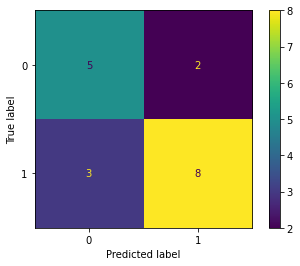

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt

# assume we have a series of observed and predicted labels
y_real = [1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,1,0,0]
y_pred = [1,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0]

# first we build a confusion matrix object...
matrix = confusion_matrix(y_real, y_pred)

#... which we then plot
ConfusionMatrixDisplay(matrix).plot()
plt.show()

### A quick disclaimer: `predict` vs. `predict_proba`

In `scikit-learn` (and `scikit-learn`-friendly libraries such as XGBoost and LightGBM) all classifiers contain at last two methods: `predict` and `predict_proba`. 

Their difference is straightforward: `predict` returns the predicted classes (0 or 1 in the binary case) whereas `predict_proba` returns a float between 0 and 1, with the score.
> For most models, the output of `predict_proba` is **not** a probability, but simply a score. We will discuss this better in the calibration section.

To exemplify this, let's use a simple logistic regression model and see how it works.

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [5]:
x = X_train[25,:].reshape(1,-1) # take one training sample for us to predict
model.predict(x)

array([1])

In [6]:
model.predict_proba(x)

array([[0.12682433, 0.87317567]])

What `predict_proba` does is output two values: the probability that the $y=0$ given $x$ (12.7% here), and the probability of $y=1$ given $x$ (87.3%). In other words, it outputs $(1-\mbox{score}, \mbox{score})$. 
> Since we are in a binary case, we can just extract the last component via `model.predict_proba(x)[:,1]`, since the 0th component will be fully determined by it. In the multiclass case (with more than two classes) then it is important to have all components given.

What `predict` does is to take the result of `predict_proba` and binarize it - essentially by just **applying a threshold of 0.5**! In order to keep things within our control, we recommend to simply use the predicted score via `predict_proba` and then feed it to different metrics.

In [7]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

### How well did our model do?

Looking into the documentation, you might be tempted to use the model's `.score` function:

In [8]:
print(">> Don't use this function")
print("Train score: {}".format(model.score(X_train, y_train)))
print("Test score: {}".format(model.score(X_test, y_test)))

>> Don't use this function
Train score: 0.6762857142857143
Test score: 0.668


But we recommend you to never use the `score` function - since under the hood it calculates accuracies with the `predict` function, which we don't recommend.

Instead, we will present you with three useful threshold-independent metrics in what follows: the ROC AUC, average precision, and lift/delinquency curves.
> We recommend you always use them all for your model assessments.

### Ratios of the confusion matrix

For now, fix a confusion matrix (this amounts to fixing an estimator $\hat y(x)$, or equivalently, to training a score function $p(x)$ and fixing a threshold). One could ask questions such as: out of all the real positives, how many did we get right? Or, out of all the positives that we predicted, how many were actually positive? 

In most references, you will see these *rates* defined in terms of elements of the confusion matrix. Here, in order to keep up with the probabilistic language we have been using, we will define them a bit differently.

[**True positive rate / sensitivity / TPR**] The TPR of an estimator is $$\mathbb{P}(\hat y(x) = 1 | Y = 1),$$ that is, the probability that we predict a positive if that was indeed an element of the positive class.

[**False positive rate, FPR**] The FPR of an estimator is $$\mathbb{P}(\hat y(x) = 1 | Y = 0),$$ that is, the probability that we predict a positive for a member of the negative class.

Similar definitions can be made for the true negative rate and false negative rate, although these tend to be less commonly used.

[**Calculating TPR from the confusion matrix**] TPR can be approximated from the confusion matrix via

$$\widehat{\mathrm{TPR}} = \frac{\mathrm{\widehat{TP}}}{\mathrm{\widehat{TP}+\widehat{FN}}}$$

> Proof: from the definition of conditional probability,
$$\mathrm{TPR} = \mathbb{P}(\hat y(x) = 1 | y = 1) = \frac{\mathbb{P}(\hat y(x) = 1 \cap y = 1)}{\mathbb{P}(y=1)}.$$ We can break the denominator into $$\mathbb{P}(y=1) = \mathbb{P}(\hat y(x) = 1 \cap y =1) + \mathbb{P}(\hat y(x)=0 \cap y=1).$$ (see note below on why) Then $$\mathrm{TPR} = \mathbb{P}(\hat y(x) = 1 | y = 1) = \frac{\mathbb{P}(\hat y(x) = 1 \cap y = 1)}{\mathbb{P}(\hat y(x) = 1 \cap y =1) + \mathbb{P}(\hat y(x)=0 \cap y=1)} = \mathrm{\frac{TP}{TP+FN}}.$$ But we have seen before that $\mathrm{\widehat{TP}}/N$ is an unbiased estimator for $\mathbb{P}(\hat y(x) = 1 \cap y = 1)$, and similarly for false negatives, so "plugging hats" on all estimators on the right-hand side yields the final result. 



> Note: this comes from the general identity $\mathbb{P}(A) = \sum_i \mathbb{P}(A \cap B_i)$ where each $B_i$ is independent of the others, and together "reconstruct" $A$ in the sense that $A = \cup_i (A \cap B_i)$. Convince yourself of that drawing a few Venn diagrams

[**Calculating FPR from the confusion matrix**] Similar to TPR, one can calculate

$$\mathrm{\widehat{FPR} = \frac{\widehat{FP}}{\widehat{FP} + \widehat{TN}}}$$

## The ROC curve and the ROC AUC

The area under the ROC curve (ROC AUC) is, perhaps surprisingly, both the most used and the least understood metric in machine learning. In what follows we give a mathematically sound treatment of it. The main results will be highlighted, in case you want to skip the heavy math.

`scikit-learn` makes everything seem like it is easy. It is literally just one line in order to calculate the ROC AUC of our model:

In [9]:
from sklearn.metrics import roc_auc_score

print("Train ROC AUC: {0:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("Test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred)))

Train ROC AUC: 0.7614
Test ROC AUC: 0.7458


But it is another thing to understand what is going on under the hood. We explain this below.

### Constructing the ROC curve

From now on, we drop the hats on $\widehat{\mathrm{FPR}}, \widehat{\mathrm{TPR}}$ etc. 

Notice that the whole discussion so far has considered a fixed estimator $\hat y$, which in turn means we have a fixed threshold $\lambda$ such that $\hat y(x)=1$ if $f(x) \geq \lambda$ and 0 otherwise.

Now, we **let $\lambda$ vary from low to high**, and consider what happens to the $(x=\mathrm{FPR}, y=\mathrm{TPR})$ plane as $\lambda$ changes.

[**Definition**] Let $\mathrm{FPR}(\lambda)$, $\mathrm{TPR}(\lambda)$ denote the false & true positive rates at threshold $\lambda$. Then, the curve $\lambda \mapsto (\mathrm{FPR}(\lambda), \mathrm{TPR}(\lambda))$ obtained when $\lambda$ varies between $]-\infty, \infty[$ is called the **receiver operating characteristic (ROC) curve**.

Before we use `scikit-learn` to plot it, let us intuitively understand what behaviors to expect from this curve. Consider the expression

$$\hat{y}(x) = \begin{cases}
1 & \mbox{if } f(x) \geq \lambda \\
0 & \mbox{if } f(x) < \lambda
\end{cases}
$$

When $\lambda = - \infty$ (or just super small), there is no way that $f(x) < \lambda$, and so we never predict 0's. In other words, our estimator is just $\hat y(x) \equiv 1$ for all $x$. This estimator:
* Gets all members of the positive class $(y=1)$ correctly, so the true positive rate is maximal
* But it gets all members of the negative class $(y=0)$ wrongly. There are no true negatives nor false negatives.

Hence it is easy to check that $\mathrm{FPR} = \mathrm{TPR} = 1$. This marks the point $(1,1)$ in the $\mathrm{FPR-TPR}$ plane.

Now go to the other extremum when $\lambda = +\infty$. Now the situation is reversed: $\hat y(x) \equiv 0$ for all $x$. Now there are no true nor false positives, so the numerators of both $\mathrm{TPR, FPR}$ are 0, and we get the point $(0,0)$. For intermediate values of $\lambda$, the curve will live inside the unit square:

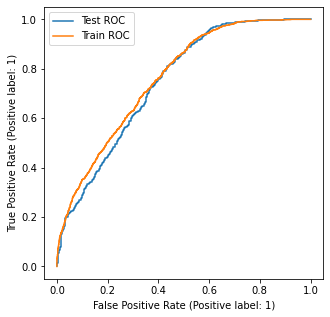

In [10]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(5,5))

RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train, y_train_pred, ax=ax, label='Train ROC')

plt.legend()
plt.show()

This is the ROC curve. It is a non-decreasing function in the (FPR, TPR) plane, ranging from (0,0) to (1,1). Notice how test and train ROC curves are similar, but different.

There are **four unique properties satisfied by the ROC curve** which we will discuss going forward:

1. Interpretable area under the curve (ROC AUC)
2. Invariance under class imbalance
3. Existence of a universal baseline
4. Convexity 

#### 1. Interpretable area under the curve (ROC AUC)

The area under the ROC curve (usually called ROC AUC or just AUC) is the most used metric in machine learning, yet many data scientists don't know its interpretation. We explain it (and prove why it is so) in what follows.

* Randomly take a point of the positive ($y=1$) class, and calculate its score $f(X_1)$
* Randomly take a point of the negative ($y=0$) class, and calculate its score $f(X_0)$

Claim: $$\boxed{\mathrm{ROC\;AUC} = \mathbb{P}(f(X_1) \geq f(X_0))},$$

that is: **the ROC AUC measures how likely it is that a point of the positive class scores higher than a point of the negative class**.

> This result is proven in the Appendix of this chapter.

Hence, in our example (where both train & test AUCs are close to 80.3%): there is a probability of 80.3% of a point in the positive class scoring higher than a point in the negative class. This is very good - 4 out of 5 times we will correctly sort them under the score.

**Numerically testing this claim**: let us run a series of samplings to check if we obtain a similar fraction to the ROC AUC we calculated above.

In [11]:
import pandas as pd

df = pd.DataFrame({'score': y_test_pred, 'label': y_test})
print(df.head().round(3).to_string())

n_samples = 10000

# randomly sample scores from class 1 and 0
class_1_score_samples = df[df['label']==1]['score'].sample(n_samples, replace=True, random_state=0)
class_0_score_samples = df[df['label']==0]['score'].sample(n_samples, replace=True, random_state=1)

# check how many times class 1 score higher
total = (class_1_score_samples.values >= class_0_score_samples.values).sum()

print("-> Percentage of times score for class 1 was higher than class 0: {0:.1f}%".format(100* total/n_samples))

   score  label
0  0.059      0
1  0.214      0
2  0.750      1
3  0.636      1
4  0.253      0
-> Percentage of times score for class 1 was higher than class 0: 74.5%


As we can see, this works - the percentage of times was very close to the 75.6% ROC AUC we got!

**Properties**:
* This characterization of the ROC AUC allows one to extract interesting insights on how the AUC will behave under some transformations. For example: given the ROC AUC of a classifier $f(x)$, how will it change if we change the classifier to $10 f(x)$? Or $f(x)^2$?
> Answer: it will stay the same. Since $\mathrm{ROC\,AUC} = \mathbb{P}(Z_1 \geq Z_0)$, any function $\phi$ applied to both sides of the inequality which does not change it will keep ROC AUC constant: $$(Z_1 \geq Z_0)\,=\,(\phi(Z_1) \geq \phi(Z_0)).$$ In particular this is true for functions like $\phi(Z) = 10Z$ or $\phi(Z) = Z^2$, which are monotonic functions. We can also see this numerically:

In [12]:
print("Original test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Applying 10x: {0:.4f}".format(roc_auc_score(10*y_test, 10*y_test_pred)))
print("Applying square: {0:.4f}".format(roc_auc_score(y_test**2, y_test_pred**2)))

Original test ROC AUC: 0.7458
Applying 10x: 0.7458
Applying square: 0.7458


* This also explains why **ROC AUC is the best metric when one is interested in sorting values based on the score**. This is particularly the case in credit scoring, where one usually takes a list of potential individuals, scores them using a classification model, and sorts them (from good scores to bad scores) in order to shortlist those which are creditworthy. Notice that a person's absolute score does not matter - what matters is how high it scores on the list *compared to others*. In this sense, **a good model will have high AUC**, because it **ranks** points well.

* **ROC AUC is blind to intra-class score performance**. Suppose we have the following model (based on a real-life buggy model I once built):
  * For members of the positive class, it mostly predicts a random score between 70%-100%
  * For members of the negative class, it mostly predicts a score of 0%
  
  This model will have very high AUC, because there is a high chance that a point in the positive class scores higher than one in the negative class. However, this model does a **terrible** job regarding **scoring** within each class, since it is essentially random (for the positive class) and all identical to zero (for the negative class)

#### 2. Invariance under class imbalance

As we discussed in Chapter 1, class imbalance is one of the biggest sources of complexity in classification problems. We claim that the ROC AUC is "invariant under" class imbalance. What does it mean?

First, let us clarify one thing. Physicists reading this probably feel like invariance under something is a positive thing, but this is not necessarily true in machine learning.

Invariance under class imbalance means that the ROC AUC (and the ROC curve more generally) do not change if we change the relative proportion of the positive and negative classes. To see this, notice how
$$\mathrm{TPR} = \mathbb{P}(\hat y(x)=1|y=1) \approx \frac{\mbox{true positives}}{\mbox{all positives}}$$
$$\mathrm{FPR} = \mathbb{P}(\hat y(x)=1|y=0) \approx \frac{\mbox{false positives}}{\mbox{all negatives}};$$
the ratio $\mbox{all positives/all negatives}$ never appears. FPR and TPR only care about **intra-class ratios, but not inter-class**.

* The good thing about this is that AUC analysis works the same for balanced or imbalanced problems...
* The bad part is that if you blindly run AUC analysis *alone*, you are shortsighting yourself to class imbalance issues. You might think that a model is very good, when it actually is not!
> As a spoiler: metrics such as precision do depend on class imbalance, as we will see further down.

#### 3. Existence of a universal baseline

It is common knowledge that the **diagonal** line in the ROC plane is the baseline corresponding to a random classifier. More formally, consider that $\hat y$ is a biased coin toss (Bernoulli trial) with parameter $p$, which does not depend on $x$. Then the probability of $\hat y$ independs on whether $y=1$ or $0$, and we have

$$\mathrm{TPR} = \mathbb{P}(\hat y(x)=1 | y=1) = \mathbb{P}(\hat y = 1) = p$$
$$\mathrm{FPR} = \mathbb{P}(\hat y(x)=1 | y=0) = \mathbb{P}(\hat y = 1) = p$$

Thus this random classifier corresponds to the point $(p,p)$ in the plane. If we consider all possible $p$'s between 0 and 1, we get the 45 degree diagonal line.

> In practice, this will happen in the case of infinitely large sample size. Below we show the test ROC for the Logistic Regression model; a random classifier; and the theoretical random classifier. Notice how the "real" random classifier is noisy.

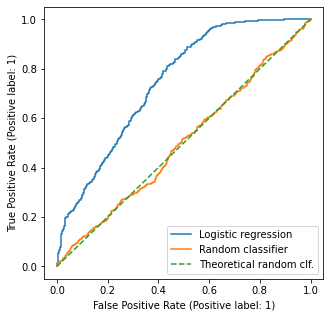

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

# completely random classifier, generating random scores between [0,1]
np.random.seed(123)
y_pred_random = np.random.rand(*y_test_pred.shape)

# theoretical random classifier
p = np.linspace(0,1)

RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax, label='Logistic regression')
RocCurveDisplay.from_predictions(y_test, y_pred_random, ax=ax, label='Random classifier')
plt.plot(p,p,linestyle='--', label='Theoretical random clf.')
plt.legend()
plt.show()

Because of this baseline, ROC AUC is theoretically bounded between 0.5 (area of the triangle below the 45 degree line) and 1. 

#### 4. Convexity

Convexity is a geometrical property of sets which will allow us to construct new (and better) classifiers based on old ones.

Suppose we have two estimators A and B, represented in the FPR/TPR plane as below (A in red, B in blue). Recall that an estimator is a function that outputs either 0 or 1.

**Convexity** allows us to build a whole family of estimators in the line segment between A and B (represented in a dotted line).

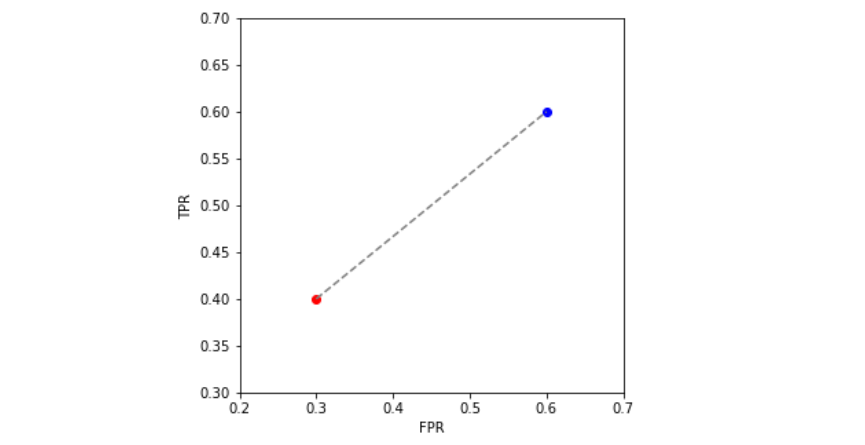

The procedure on how to do it (which is not as important as knowing we can do it!) follows below:

[**Theorem**] Let $c_A, c_B$ be the two binary classifiers (i.e. taking values in $\{0,1\}$). Let $(\mathrm{FPR_A, TPR_A})$ and $(\mathrm{FPR_B, TPR_B})$ denote the coordinates of the two classifiers. Consider a point $(\mathrm{FPR_*, TPR_*})$ in the segment between A and B. Let 

$$p = \mathrm{\frac{FPR_*-FPR_A}{FPR_B-FPR_A}}.$$

Then the classifier $c_*$ defined as

$$c_*(x) = \begin{cases}
c_A(x) & \mbox{with probability $1-p$}\\
c_B(x) & \mbox{with probability $p$}
\end{cases}$$

attains a FPR of $\mathrm{FPR_*}$ and TPR of $\mathrm{TPR_*}$.

> Proof: we do the calculation for FPR; that of TPR follows analogously. By definition, the FPR of $c_*$ is 
$$\begin{align}
\mathbb P (c_*(x) = 1 | y = 0) &= p\, \mathbb P (c_B(x)=1|y=0) + (1-p) \,\mathbb P(c_A(x)=1|y=0) \\
&= p \,\mathrm{FPR_B} + (1-p) \,\mathrm{FPR_A} = \mathrm{FPR}_*
\end{align}$$as claimed.

The importance of this result is that it gives an **optimal boundary** for a set of classifiers. Consider the situation below, where a new classifier $C$ (orange) lies in the region below the segment AB. $C$ is, *in any sense*, worse then the projection $C'$ (black) of C onto segment AB, since it has a higher TPR for the "cost" of the same FPR. 

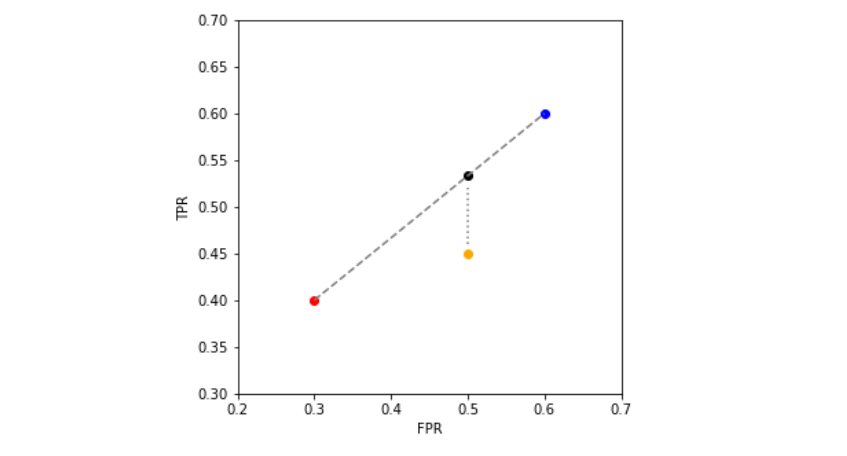

Because of this, when given a classifier $f(x)$, one is allowed to take the **convex hull** of the ROC curve (think of it as "laying a rubber band" on top of the your points:

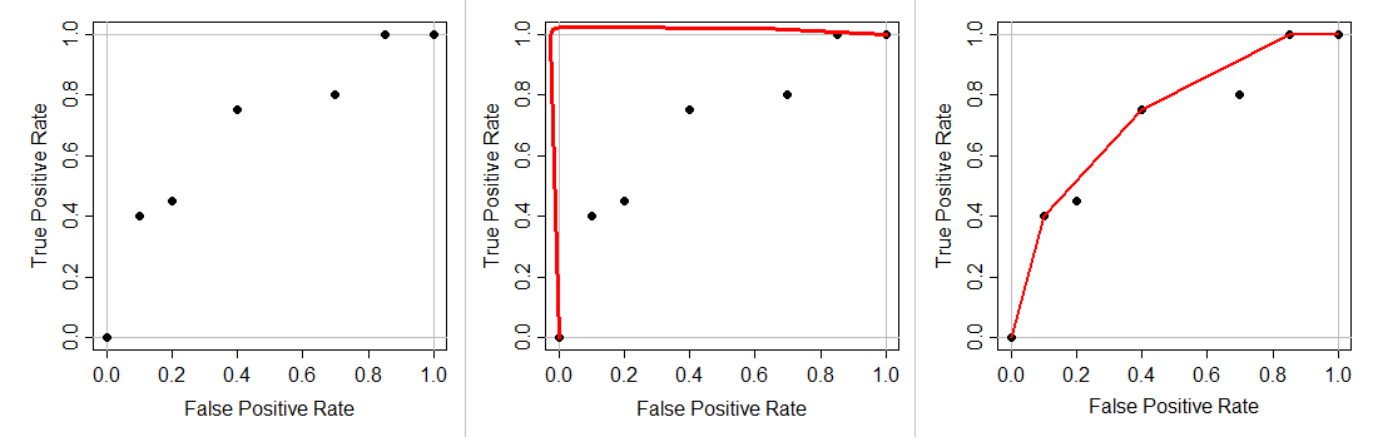

We can build a function which creates the convex hull and also computs its AUC as below:

In [21]:
def hull_roc_auc(y_true, y_score):
    """
    Computes coordinates (TPR, FPR) and ROC AUC for the convex hull 
    of a ROC curve built from a ground truth y_true (0s and 1s) and 
    a vector of scores y_score
    """

    from sklearn.metrics import roc_curve, auc
    from scipy.spatial import ConvexHull

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # add artificial vertex at (1,0)
    fpr, tpr = np.append(fpr, [1]), np.append(tpr, [0])

    points = np.array([fpr, tpr]).T
    hull = ConvexHull(points)

    # get vertices and remove artificial vertex
    vertices = np.array([points[v] for v in hull.vertices if not np.array_equal(points[v],np.array([1., 0.]))])
    fpr_hull, tpr_hull = vertices[:,0], vertices[:,1]

    # hull AUC
    hull_auc = auc(fpr_hull, tpr_hull)
    
    return hull_auc, fpr_hull, tpr_hull

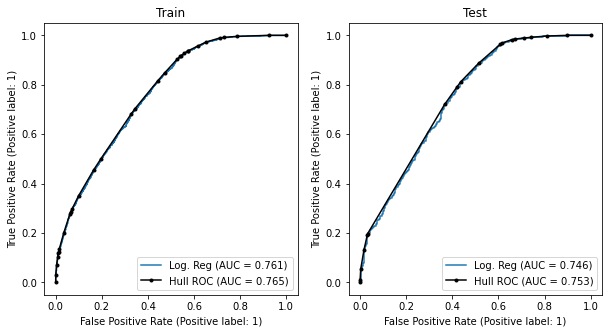

In [22]:
# Calculate variables for hull - train/test
hull_auc_train, fpr_hull_train, tpr_hull_train = hull_roc_auc(y_train, y_train_pred)
hull_auc_test, fpr_hull_test, tpr_hull_test = hull_roc_auc(y_test, y_test_pred)

## Plot
fig, ax = plt.subplots(figsize=(10,5), ncols=2)

# original ROC
original_auc_train = roc_auc_score(y_train, y_train_pred)
RocCurveDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], 
                                 label=f'Log. Reg (AUC = {round(original_auc_train, 3)})')

original_auc_test = roc_auc_score(y_test, y_test_pred)
RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], 
                                 label=f'Log. Reg (AUC = {round(original_auc_test, 3)})')

# convex hull
ax[0].plot(fpr_hull_train, tpr_hull_train, label=f"Hull ROC (AUC = {round(hull_auc_train,3)})", marker='.', color='black')
ax[1].plot(fpr_hull_test, tpr_hull_test, label=f"Hull ROC (AUC = {round(hull_auc_test,3)})", marker='.', color='black')

# legends/labels
ax[0].legend(); ax[1].legend()
ax[0].set_title("Train"); ax[1].set_title("Test")
plt.show()

### Is this cheating?

No. It is a remarkable property of the "ROC space" (FPR vs TPR) that linear interpolation between classifiers yields a new classifier. Since we do not have access to the "true" distribution of $f(X)|Y$, the best we can do is use its empirical distribution and build the best possible ROC curve out of it.

### Takeaways

* The ROC curve represents a machine learning classifier in the TPR / FPR plane
* If it is not convex, it can be made convex by connecting points via line segments. This is equivalent to building new classifiers as probabilistic samplings of the endpoint classifiers
* The area under the ROC curve (ROC AUC) represents the likelihood that a point of the positive class scores higher than one in the negative class. It is bound between 0.5 and 1.0
* The ROC curve (and thus the ROC AUC) are invariant under rebalancing of the positive / negative classes. This is both good and bad

---

# Appendix: 
## Proof of probabilistic interpretation of the ROC AUC

Here, we prove the claim that, if $f$ is a trained binary classification model,

$$\mathrm{ROC\;AUC} = \mathbb{P}(f(X_1) \geq f(X_0) | Y_1 = 1, Y_0 = 0),$$


**Proof**: by definition, 

$$\mathrm{ROC\;AUC} = \int_{\mathrm{FPR}=0}^{\mathrm{FPR}=1} \mathrm{TPR}\, d\mathrm{FPR}.$$

It is natural to parameterize FPR and TPR via the threshold $\lambda$ since $\mathrm{TPR} = \mathbb{P}(f(X)\geq \lambda | Y=1)$ and $\mathrm{FPR} = \mathbb{P}(f(X) \geq \lambda | Y=0)$. This motivates us to define the *independent* random variables 

$$Z_1 = (f(X)|Y=1),\qquad Z_0 = (f(X)|Y=0),$$

for which $\mathrm{TPR}(\lambda) = \mathbb{P}(Z_1 \geq \lambda)$ for instance. This can be written as

$$\mathrm{TPR}(\lambda) = \int_\lambda^\infty g_1(z) dz,\qquad \mathrm{FPR}(\lambda) = \int_\lambda^\infty g_0(z) dz$$ 

where $g_0, g_1$ are the PDFs of $Z_0$ and $Z_1$ respectively. 

Plugging these back into the definition of ROC AUC gives 

\begin{align*}
\mathrm{ROC\,AUC} &= \int_{\mathrm{FPR}=0}^{\mathrm{FPR}=1} \mathrm{TPR}\, d\mathrm{FPR} \\
&= \int_{\lambda=\infty}^{\lambda=-\infty} \mathrm{TPR}(\lambda) \frac{ d \mathrm{FPR}(\lambda)}{d\lambda} d\lambda \\
&= \int_\infty^{-\infty} d\lambda \int_\lambda^\infty dz\, g_1(z) (-g_0(\lambda)),
\end{align*}

where we have used the fundamental theorem of calculus in the last equality. Now one can equivalently write these iterated integrals as

$$\int_{-\infty}^\infty \int_{-\infty}^\infty \mathbf{1}_{z \geq \lambda} g_0(\lambda) g_1(z)\, dz d\lambda = \mathbb{E}[\mathbf{1}_{Z_1 \geq Z_0}] = \mathbb{P}(Z_1 \geq Z_0),$$

where we identify $g_0(\lambda)g_1(z)$ as the PDF for $(Z_0, Z_1)$ since these are independent variables.

## Further properties of the ROC curve

There is an interesting characterization of the ROC curve based on the cumulative distribution functions (CDFs) of the variables

$$Z_0 = (f(X)|Y=0),\qquad Z_1 = (f(X)|Y=1)$$

Let $F_i(t) := \mathbb{P}(Z_i < t)$, for $i \in \{0, 1\}$, denote the CDFs. We want to write the false & true positive rates with respect to these CDFs. Notice that, as functions of the threshold $\lambda$,

$$\begin{align}
\mathrm{TPR}(\lambda) &= \mathbb P(\hat y_\lambda(X) = 1 | Y = 1)\\
&= \mathbb P (f(X) \geq \lambda | Y = 1)\\
&= 1- \mathbb P (f(X) < \lambda | Y=1) = 1 - \mathbb P (Z_1 < \lambda)\\
&= 1 - F_1(\lambda)
\end{align}$$

Similarly,
$$\mathrm{FPR}(\lambda) = 1 - F_0(\lambda)$$

We can explicitly write $\mathrm{TPR}$ as a function of $\mathrm{FPR}$ if we invert the last expression for $\lambda$, obtaining $\lambda = F_0^{-1}(1-\mathrm{FPR})$; then
$$\boxed{\mathrm{TPR} = 1 - F_1(F_0^{-1}(1-\mathrm{FPR}))}$$

To simplify notation, call $x \equiv \mathrm{FPR}$ and $y \equiv \mathrm{TPR}$ (don't confuse with variables $X$ and $Y$; this is just a notation which reminds who goes in the vertical and horizontal axes). We can equivalently write

$$\begin{cases}
x &= 1 - F_0(\lambda)\\
y &= 1 - F_1(\lambda)
\end{cases} \qquad \mbox{or}\qquad y = 1 - F_1(F_0^{-1}(1-x))$$

From either expression, one can take the derivative and see that (calling $f_i(t) \equiv F_i'(t)$ the PDFs)

$$\frac{dy}{dx} = \frac{f_1(F_0^{-1}(1-x))}{f_0(F_0^{-1}(1-x))} \geq 0$$

since the PDFs are always non-negative, and so is their ratio. So we see that the ROC curve is necessarily non-decreasing.

It has, however, no obligation of being **concave** (= curved face-down), even if that is how we usually draw it. Taking a second derivative of the expression above yields

$$\frac{d^2y}{dx^2} = - \frac{f_1'}{f_0^2} + \frac{f_1 f_0'}{f_0^3}$$

where all quantities are calculated at $F_0^{-1}(1-x)$. Since derivatives of both $f_1$ and $f_0$ appear, and they can take any sign, there is no obvious sign for the expression above.

## References:
Peter Flach, Meelis Kull, *Precision-Recall-Gain Curves: PR Analysis Done Right*, NIPS 2015

## Further reading:
https://arxiv.org/pdf/1809.04808.pdf on the concavity of ROC curves 